In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
import tensorflow as tf
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8186239545034161544
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1747976192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16662228025609013076
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
2.10.1


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128
img_path_train = "datasets/food-101/food-101/images/"

train_datagen = ImageDataGenerator(rescale= 1.0/255, validation_split=0.2)


train_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(128,128),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(img_path_train,
                                                    target_size=(128,128),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    shuffle=True,
                                                    subset='validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [4]:
df = pd.read_csv('datasets/nutrition101 (1).csv')
protein_labels = list(df['protein'])
name_labels = list(df['name'])

In [5]:
def regression_gen(flow_from_directory_gen, list_of_values):
    for x, y in flow_from_directory_gen:
        # print(y)
        # print(np.array([list_of_values[int(y_i)] for y_i in y]))
        yield x, np.array([list_of_values[int(y_i)] for y_i in y])
        # yield x, np.array([list_of_values[(y_i)] for y_i in y])

In [30]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam


# Initialising the CNN
model = Sequential()

#Convolution 1
# model.add(Conv2D(32,(5, 5), padding='same', input_shape=(128, 128, 1)))
# model.add(Activation('relu'))
# model.add(BatchNormalization(trainable=True))
model.add(Conv2D(32,(11, 11), activation = "relu", padding='same', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2,2)))

# #Convolution 2
# model.add(Conv2D(64,(3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization(trainable=True))
model.add(Conv2D(64,(5, 5), activation = "relu", padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3, 3), activation = "relu", padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3, 3), activation = "relu", padding='same'))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
# model.add(Dense(128))
# model.add(Activation('relu'))
model.add(Dense(1024, activation = "relu"))
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))

# model.add(Dense(nb_classes))
model.add(Dense(1, activation='linear'))

print(model.summary())

opt = Adam(learning_rate=0.1)
# model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      3904      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 128)     

In [26]:
# number of epochs to train the NN
epochs = 1

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
with tf.device('/gpu:0'):
    history = model.fit(
        regression_gen(train_generator, protein_labels),
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=epochs,
        validation_data = regression_gen(validation_generator, protein_labels),
        validation_steps = validation_generator.n//validation_generator.batch_size,
        # callbacks=callbacks_list
    )

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/batch_normalization/FusedBatchNormGradV3' defined at (most recent call last):
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Emeze\AppData\Local\Temp\ipykernel_22932\4220587605.py", line 10, in <module>
      history = model.fit(
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Emeze\miniconda3\envs\tf2\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/batch_normalization/FusedBatchNormGradV3'
OOM when allocating tensor with shape[128,32,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/batch_normalization/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10474]

In [23]:
sample_batch = next(regression_gen(train_generator, protein_labels))

1.6
1/1 [==============================] - 0s 27ms/step


[[-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]
 [-0.3972868]]


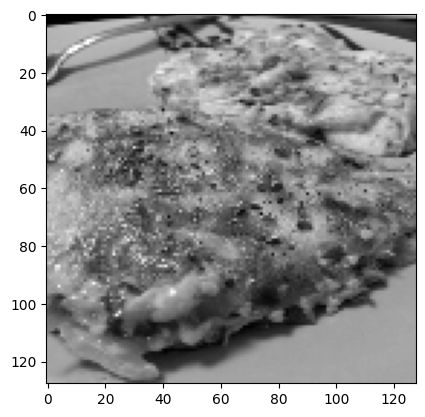

In [24]:
# print(name_labels[int(sample_batch[1][0])])
print(sample_batch[1][0])
print(model.predict(sample_batch[0][0:10, :, :, :]))
plt.imshow(sample_batch[0][0, :, :, :], cmap="gray")